# Plot for paper

In [1]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm


plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "serif",
    "font.serif": "newcent",
    "text.latex.preamble": "\\usepackage[T1]{fontenc}\n\\usepackage{fourier}",
    
})

## Datasets selection

In [2]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 1000                      # Number of segments in the Kramers chain
n_ensemble = 1000                     # Number of molecules to simulate

# Input folder
data_folder = 'outputs/Kramers'
                    
# Name: file
scenarios = [
#    'turbulence_1',
    'inkjet_0',
    'contraction_0',
    'elongation_0_noBF',
    'sonication_0',
    'elongation_0_noBF_DP1.01',
]

# Load data with rescaling
dataset = {}
for scenario in scenarios:
    with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.npz") as data:
        temp = dict(data)
        # Rename and normalise variables
        tau = 0.0142*n_links**2
        temp['A'] = temp.pop('A_average')/n_links**2
        temp['∇U'] = temp.pop('gradU')*tau
        temp['t'] = temp['t']/tau
        # Add transposed variables
        temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        # Add features
        temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
        temp['tr(A∇U)'] = np.trace(temp['A']@temp['∇U'], axis1=1, axis2=2)     
        
        # Flow properties
        temp['epsilon_dot'] = np.linalg.eigvalsh(0.5*(temp['∇U'] + temp['∇Uᵀ']))
        
        # Effective principal strain rate
        temp['epsilon_dot_eff'] = temp['tr(A∇U)']/temp['tr(A)']
        
        # Estimates of the Henky strain, one using principal strain rates, the other using polymer extension
        epsilon = np.zeros_like(temp['t'])
        epsilon_eff = np.zeros_like(temp['t'])
        for i, dt in enumerate(np.diff(temp['t'])):
            epsilon[i+1] = (np.amax(temp['epsilon_dot'][i]) + epsilon[i]/dt)/(1./dt + 1./1.)
            #h_prime[i+1] = (temp['tr(A∇U)'][i]/temp['tr(A)'][i] + h_prime[i]/dt)/(1./dt + 1./1.)
            epsilon_eff[i+1] = temp['epsilon_dot_eff'][i]*dt + epsilon_eff[i]
        temp['epsilon'] = epsilon
        temp['epsilon_eff'] = epsilon_eff
        
        # Effective square segment
        g_maxf = temp['g_max'].copy()
        g_maxf[g_maxf<4] = 0
        temp['L2'] = g_maxf/temp['epsilon_dot'][:,2]*0.0142*8
        temp['M2'] = temp['g_12']/temp['epsilon_dot'][:,2]*0.0142*8


        # Save
        dataset[scenario] = temp

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


## Plot flow characteristics

/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


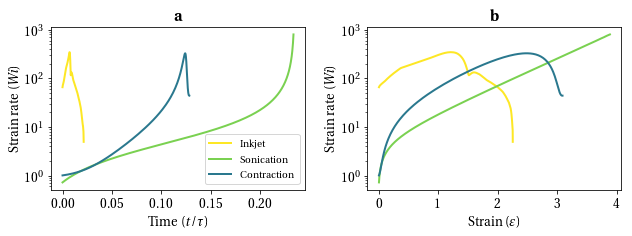

In [3]:
cols = ['#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154']

sonication_ls = {'color': '#7ad151',
                'linewidth': 2,
                'linestyle': 'solid'}

contraction_ls = {'color': '#2a788e',
                'linewidth': 2,
                'linestyle': 'solid'}

inkjet_ls = {'color': '#fde725',
                'linewidth': 2,
                'linestyle': 'solid'}

elongation_noBF_ls = {'color': 'k',
                'linewidth': 1,
                'linestyle': ':'}


plt.rcParams['figure.figsize'] = [9, 3.5]
fig, ax = plt.subplots(ncols=2)

ax[0].semilogy(dataset['inkjet_0']['t'], dataset['inkjet_0']['epsilon_dot'][:,2], **inkjet_ls, label='Inkjet')
ax[0].semilogy(dataset['sonication_0']['t'][:-141], dataset['sonication_0']['epsilon_dot'][:-141,2], **sonication_ls, label='Sonication')
ax[0].semilogy(dataset['contraction_0']['t'][:-90], dataset['contraction_0']['epsilon_dot'][:-90,2], **contraction_ls, label='Contraction')
ax[0].set_xlabel('Time ($t/\\tau$)')
#ax[0,0].set_xlim(0,6)
ax[0].set_ylabel('Strain rate (\\textit{Wi})')
ax[0].legend(fontsize=11, loc='lower right')
ax[0].set_title('\\textbf a')


ax[1].semilogy(dataset['inkjet_0']['epsilon'], dataset['inkjet_0']['epsilon_dot'][:,2], **inkjet_ls)
ax[1].semilogy(dataset['sonication_0']['epsilon'][:-141], dataset['sonication_0']['epsilon_dot'][:-141,2], **sonication_ls, label='Sonication')
ax[1].semilogy(dataset['contraction_0']['epsilon'][:-90], dataset['contraction_0']['epsilon_dot'][:-90,2], **contraction_ls, label='Contraction')
ax[1].set_xlabel('Strain ($\\varepsilon$)')
#ax[0,1].set_xlim(0,6)
ax[1].set_ylabel('Strain rate (\\textit{Wi})')
ax[1].set_title('\\textbf b')




plt.tight_layout()
plt.savefig('plot_scenarios.pdf') 

## Plot polymers detail

/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


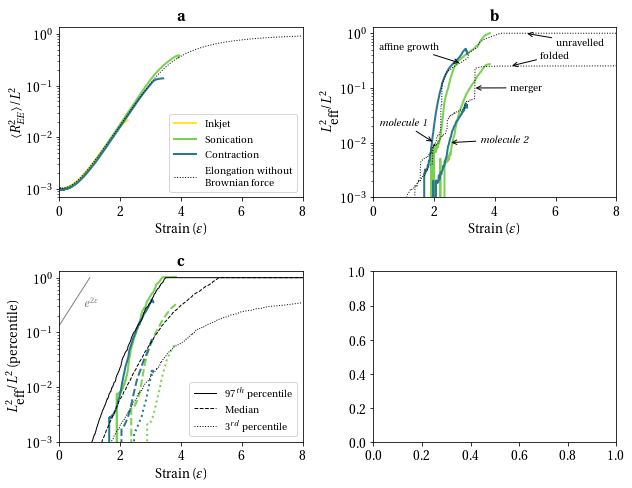

In [4]:
plt.rcParams['figure.figsize'] = [9, 7]
fig, ax = plt.subplots(ncols=2, nrows=2)

ax[0,0].semilogy(dataset['inkjet_0']['epsilon'], dataset['inkjet_0']['tr(A)'], **inkjet_ls, label='Inkjet')
ax[0,0].semilogy(dataset['sonication_0']['epsilon'], dataset['sonication_0']['tr(A)'], **sonication_ls, label='Sonication')
ax[0,0].semilogy(dataset['contraction_0']['epsilon'], dataset['contraction_0']['tr(A)'], **contraction_ls, label='Contraction')
ax[0,0].semilogy(dataset['elongation_0_noBF']['epsilon'], dataset['elongation_0_noBF']['tr(A)'], **elongation_noBF_ls, label='Elongation without\nBrownian force')
ax[0,0].set_xlabel('Strain ($\\varepsilon$)')
ax[0,0].set_ylabel('$\langle R_{EE}^2\\rangle/L^2$', labelpad=0)
ax[0,0].set_xlim(0,8)
ax[0,0].legend(fontsize=11)
ax[0,0].set_title('\\textbf a')

ax[0,1].semilogy(dataset['sonication_0']['epsilon'][:-142], dataset['sonication_0']['L2'][3,:-142], color='#7ad151', linewidth=2, label='Sonication')
ax[0,1].semilogy(dataset['contraction_0']['epsilon'][:-90], dataset['contraction_0']['L2'][3,:-90], color='#2a788e', linewidth=2, label='Contraction')
ax[0,1].semilogy(dataset['elongation_0_noBF']['epsilon'], dataset['elongation_0_noBF']['L2'][3], ls=':', color='k', linewidth=1, label='Elongation without\nBrownian force')    
# other examples
for i in [2]:
    ax[0,1].semilogy(dataset['sonication_0']['epsilon'][:-142], dataset['sonication_0']['L2'][i,:-142], color='#7ad151', linewidth=2)
    ax[0,1].semilogy(dataset['contraction_0']['epsilon'][:-90], dataset['contraction_0']['L2'][i,:-90], color='#2a788e', linewidth=2)
    ax[0,1].semilogy(dataset['elongation_0_noBF']['epsilon'], dataset['elongation_0_noBF']['L2'][i], ls=':', color='k', linewidth=1)    
# Labels
ax[0,1].annotate('unravelled', xy=(5, 1), xytext=(6, 0.6), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0,1].annotate('folded', xy=(4.5, 0.25), xytext=(5.5, 0.35), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0,1].annotate('merger', xy=(3.3, 0.1), xytext=(4.5, 0.09), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0,1].annotate('affine growth', xy=(2.9, 0.28), xytext=(0.2, 0.5), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0,1].annotate('\\textit{molecule 1}', xy=(2, 0.01), xytext=(0.2, 0.02), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0,1].annotate('\\textit{molecule 2}', xy=(2.5, 0.01), xytext=(3.5, 0.01), arrowprops=dict(arrowstyle="->"), fontsize=11)

ax[0,1].set_xlabel('Strain ($\\varepsilon$)')
ax[0,1].set_xlim(0,8)
ax[0,1].set_ylabel('$L_\\textrm{eff}^2/L^2$', labelpad=0)
ax[0,1].set_ylim(0.001,1.3)
ax[0,1].set_title('\\textbf b')


ax[1,0].semilogy(dataset['sonication_0']['epsilon'][:-142], np.percentile(dataset['sonication_0']['L2'][:,:-142], 97, axis=0), color='#7ad151', ls='-',linewidth=2)
ax[1,0].semilogy(dataset['sonication_0']['epsilon'][:-142], np.percentile(dataset['sonication_0']['L2'][:,:-142], 50, axis=0), color='#7ad151', ls='--',linewidth=2)
ax[1,0].semilogy(dataset['sonication_0']['epsilon'][:-142], np.percentile(dataset['sonication_0']['L2'][:,:-142], 3, axis=0), color='#7ad151', ls=':',linewidth=2)
ax[1,0].semilogy(dataset['contraction_0']['epsilon'][:-90], np.percentile(dataset['contraction_0']['L2'][:,:-90], 97, axis=0), color='#2a788e', ls='-',linewidth=2)
ax[1,0].semilogy(dataset['contraction_0']['epsilon'][:-90], np.percentile(dataset['contraction_0']['L2'][:,:-90], 50, axis=0), color='#2a788e', ls='--',linewidth=2)
ax[1,0].semilogy(dataset['contraction_0']['epsilon'][:-90], np.percentile(dataset['contraction_0']['L2'][:,:-90], 3, axis=0), color='#2a788e', ls=':',linewidth=2)

ax[1,0].semilogy(dataset['elongation_0_noBF']['epsilon'], np.percentile(dataset['elongation_0_noBF']['L2'], 97, axis=0), color='k', ls='-',linewidth=1, label='$97^{th}$ percentile')
ax[1,0].semilogy(dataset['elongation_0_noBF']['epsilon'], np.percentile(dataset['elongation_0_noBF']['L2'], 50, axis=0), color='k', ls='--',linewidth=1, label='Median')
ax[1,0].semilogy(dataset['elongation_0_noBF']['epsilon'], np.percentile(dataset['elongation_0_noBF']['L2'], 3, axis=0), color='k', ls=':',linewidth=1, label='$3^{rd}$ percentile')
ax[1,0].semilogy(np.linspace(0,1), np.exp(2*np.linspace(0,1)-2), color='grey', ls='-',linewidth=1) 
ax[1,0].text(0.8, 0.3, '$e^{2\\varepsilon}$', color='grey', fontsize=12)
ax[1,0].set_xlabel('Strain ($\\varepsilon$)')
ax[1,0].set_xlim(0,8)
ax[1,0].legend(fontsize=11)
ax[1,0].set_ylabel('$L_\\textrm{eff}^2/L^2$ (percentile)', labelpad=0)
ax[1,0].set_ylim(0.001,1.3)
ax[1,0].set_title('\\textbf c')



plt.tight_layout()
plt.savefig('plot_molecules.pdf') 

***

## Simulate scission

For an elongated chain, the maximum tension is at the centre and given by:
$$
g_\max = Wi\left(\frac{N^2}{8} + \frac{N}{2} \right)
$$
So a critical tension corresponds to a critical Weissenberg number
$$
Wi_c = \frac{g_c}{\frac{N^2}{8} + \frac{N}{2}}
$$
with usually $N \gg 1$ we keep the $N^2$ term only.

### Monodispersed

In [5]:
data = dataset['elongation_0_noBF']

Wi_c = 100
threshold = Wi_c/(8*0.0142)

cs_mono = []

# Tensions are going to be rescaled with Wi
Wis = np.logspace(np.log10(Wi_c)-1,np.log10(Wi_c)+2,100)

for Wi in Wis:

    events = np.zeros_like(data['t'])
    for tension_max in Wi*data['L2']/(0.0142*8):
        for i, g_max in enumerate(tension_max):
            
            if g_max > threshold:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_mono.append(c)

cs_mono = np.array(cs_mono)

### Polydispersed

In [6]:
## With PD = 1.01

data = dataset['elongation_0_noBF_DP1.01']

cs_poly = []

for Wi in Wis:

    events = np.zeros_like(data['t'])
    for tension_max in Wi*data['L2']/(0.0142*8):
        for i, g_max in enumerate(tension_max):
            
            if g_max > threshold:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_poly.append(c)

cs_poly = np.array(cs_poly)

### Model fit

In [13]:
def build_model(params):
    c_model = np.ones_like(cs_poly)
    
    for i, w in enumerate(Wis/Wi_c):
        kappa = params[0] + params[1]*np.log(w)**2
        f = 1./(1 + np.exp(-np.log(w)/params[2]))
        g = params[3]*np.log((1 + np.exp((dataset['elongation_0_noBF_DP1.01']['epsilon'] - np.log(n_links)/2 + params[4]*np.log(w))/params[3])))
        
        c_model[i] = np.exp(-kappa*f*g)
        
    return c_model


def loss(params):
    return np.sum((cs_poly-build_model(params))**2)


from scipy.optimize import minimize
                                    
res = minimize(loss, [0.4, 0.01, 0.2, 0.2, 0.25])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['kappa_0', 'kappa_1', 'gamma_0', 'gamma_1', 'beta_0']
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_model = build_model(res.x)

Optimization terminated successfully.
kappa_0 = 0.363 ± 0.010
kappa_1 = 0.366 ± 0.021
gamma_0 = 0.080 ± 0.005
gamma_1 = 0.196 ± 0.014
beta_0 = 0.234 ± 0.010


Inspect the result:

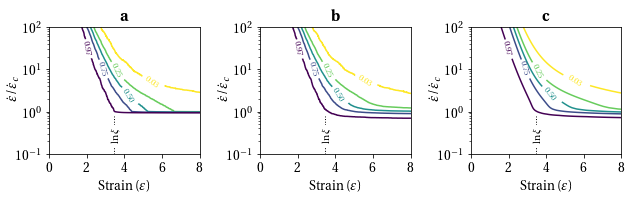

In [14]:
plt.rcParams['figure.figsize'] = [9, 3]
fig, ax = plt.subplots(ncols=3)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]
#ccols = ['#dde318', '#5ec962', '#21918c', '#3b528b', '#440154']

CS = ax[0].contour(data['epsilon'], Wis/Wi_c, cs_mono, levels, cmap='viridis_r') # viridis_r, YlGnBu
ax[0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[0].set_xlabel('Strain ($\\varepsilon$)')
ax[0].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[0].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0].set_ylim(0.1, 100)
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0].set_title('\\textbf a')


CS = ax[1].contour(data['epsilon'], Wis/Wi_c, cs_poly, levels, cmap='viridis_r')
ax[1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[1].set_xlabel('Strain ($\\varepsilon$)')
ax[1].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[1].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1].set_ylim(0.1, 100)
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1].set_title('\\textbf b')


CS = ax[2].contour(data['epsilon'], Wis/Wi_c, c_model, levels, cmap='viridis_r') 
ax[2].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[2].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[2].set_xlabel('Strain ($\\varepsilon$)')
ax[2].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[2].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[2].set_ylim(0.1, 100)
ax[2].set_xlim(0, 8)
ax[2].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[2].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[2].set_title('\\textbf c')

plt.tight_layout()
plt.savefig('plot_distributions.pdf') 

## Effect of hydrodynamic interactions

In [167]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

In [201]:
# Load data with HI

with np.load(f"{data_folder}/elongation_0_noBF_poly_HI_nlinks200_nmol1000.npz") as data:
    temp = dict(data)
    temp['A'] = temp.pop('A_average')/n_links**2
    temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
    # Effective square segment
    # Normalising factor  # 900.4341323791994
    #g_max_unravel = np.max(temp['g_max'][:, -1])
    g_max_unravel = 900.4341323791994
    
    temp['g_max_denoise'] = np.empty_like(temp['g_max'])
    for i, noisy in enumerate(temp['g_max']):
        temp['g_max_denoise'][i] = np.exp(denoise_wavelet(np.log(noisy), 
                                                       wavelet='db4', 
                                                       method='VisuShrink', 
                                                       mode='soft',
                                                       sigma=1.,
                                                       )
                                      )
    
    temp['L2'] = temp['g_max_denoise']/g_max_unravel
    temp['M2'] = temp['g_12']/g_max_unravel

    # Save
    dataset['HI'] = temp

# Equivalent without HI
with np.load(f"{data_folder}/elongation_0_noBF_poly_nlinks200_nmol1000.npz") as data:
    temp = dict(data)
    temp['A'] = temp.pop('A_average')/n_links**2
    temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
    # Effective square segment
    # Normalising factor  # 5049.999999999985
    g_max_unravel = 5049.999999999985
    temp['L2'] = temp['g_max']/g_max_unravel
    temp['M2'] = temp['g_12']/g_max_unravel

    # Save
    dataset['noHI'] = temp

410.44164735037225


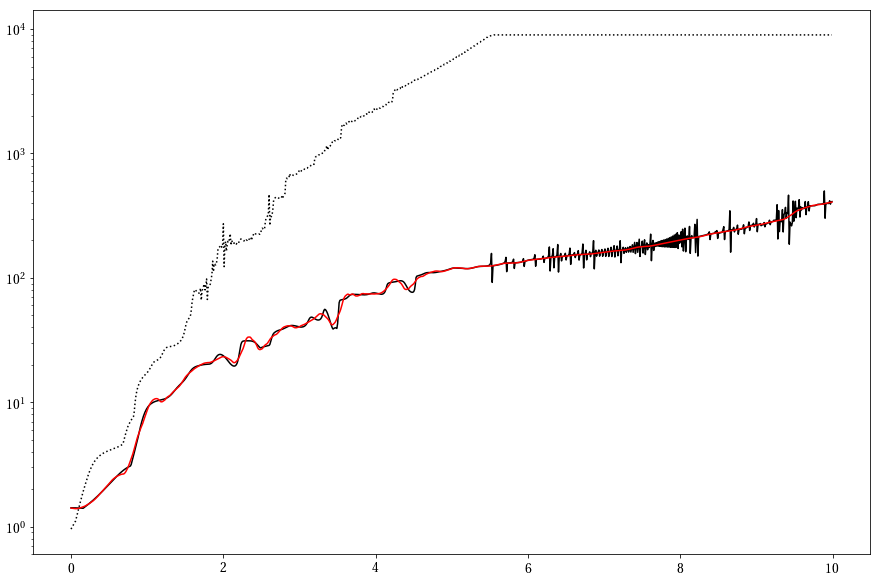

In [202]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)


i = 100

sigma_est = estimate_sigma(np.log(dataset['HI']['g_max'][i]))
print(dataset['HI']['g_max'][i][-1])

plt.semilogy(dataset['HI']['t'], dataset['HI']['g_max'][i], 'k-', label='HI')
plt.semilogy(dataset['HI']['t'], dataset['HI']['g_max_denoise'][i], 'r-', label='HI')
plt.semilogy(dataset['noHI']['t'], dataset['noHI']['g_max'][i], 'k:', label='no HI')

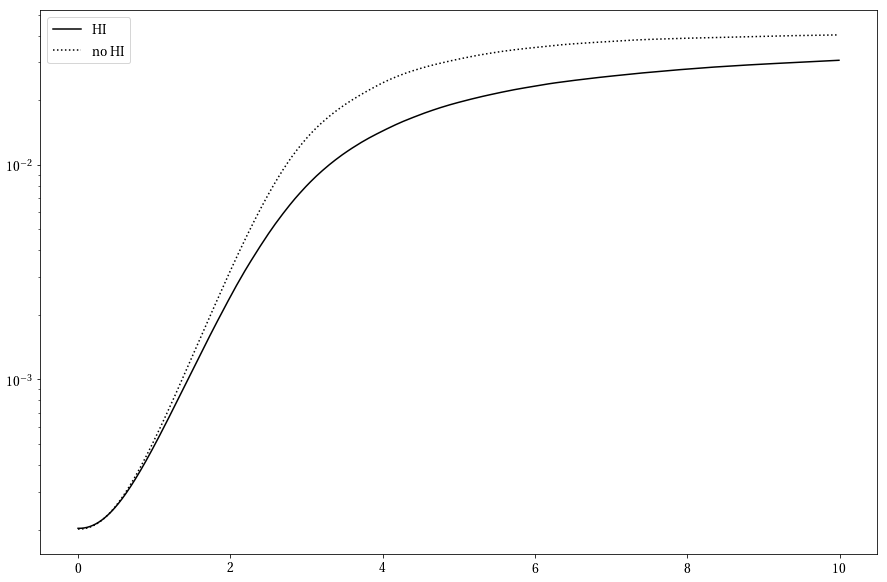

In [203]:
plt.semilogy(dataset['HI']['t'], dataset['HI']['tr(A)'], 'k-', label='HI')
plt.semilogy(dataset['noHI']['t'], dataset['noHI']['tr(A)'], 'k:', label='no HI')
plt.legend()

(0, 10)

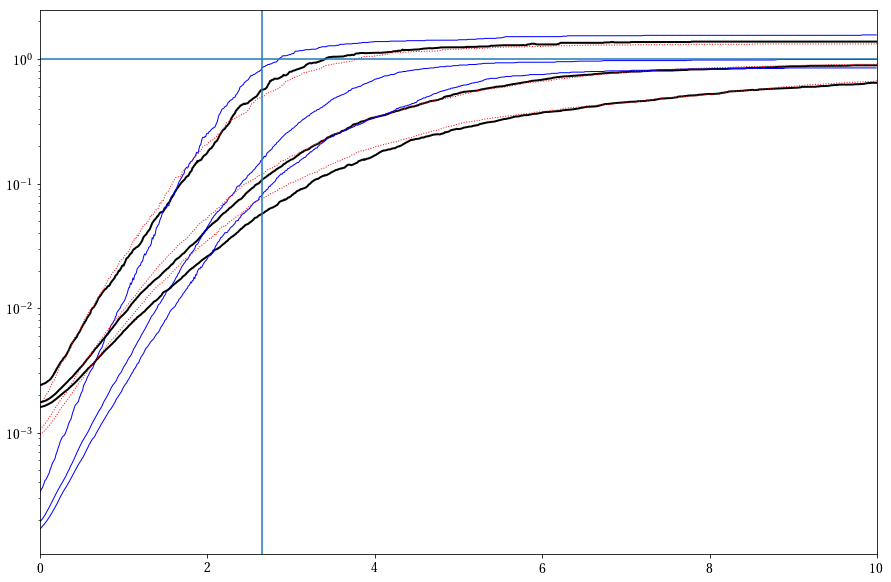

In [204]:
plt.rcParams['figure.figsize'] = [15, 10]
pool = []

for i in pool:
    plt.semilogy(dataset['HI']['t'], dataset['HI']['L2'][i], 'k-', linewidth=1)
for i in pool:
    plt.semilogy(dataset['noHI']['t'], dataset['noHI']['L2'][i], 'b-', linewidth=1)
    

for i in [97, 50, 25]:
    plt.semilogy(dataset['HI']['t'], np.percentile(dataset['HI']['L2'], i, axis=0), 'k-', linewidth=2)
    plt.semilogy(dataset['noHI']['t'], np.percentile(dataset['noHI']['L2'], i, axis=0), 'b-', linewidth=1)
    plt.semilogy(dataset['noHI']['t']+dataset['noHI']['t']**3/25, np.percentile(dataset['noHI']['L2'], i, axis=0)**0.8, 'r:', linewidth=1)

plt.axvline(np.log(200)/2)
plt.axhline(1)
plt.xlim(0,10)


In [205]:
# Scission just as function of normalised L2
ws = np.logspace(-1,2,100)


cs_HI = []

for w in ws:

    events = np.zeros_like(dataset['HI']['t'])
    for L2t in dataset['HI']['L2']:
        for i, L2eff in enumerate(L2t):
            
            if L2eff > 1./w:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_HI.append(c)

cs_HI = np.array(cs_HI)


cs_noHI = []

for w in ws:

    events = np.zeros_like(dataset['noHI']['t'])
    for L2t in dataset['noHI']['L2']:
        for i, L2eff in enumerate(L2t):
            
            if L2eff > 1./w:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_noHI.append(c)

cs_noHI = np.array(cs_noHI)


In [233]:
def build_model(params):
    c_model = np.ones_like(cs_HI)
    
    for i, w in enumerate(ws):
        kappa = params[0] + params[1]*np.log(w)**2
        f = 1./(1 + np.exp(-np.log(w)/params[2]))
        g = params[3]*np.log((1 + np.exp((dataset['HI']['t'] - np.log(params[5]**2)/2 + params[4]*np.log(w))/params[3])))
        
        c_model[i] = np.exp(-kappa*f*g)
        
    return c_model


def loss(params):
    return np.sum((cs_HI-build_model(params))**2)


from scipy.optimize import minimize
                                    
res = minimize(loss, [0.16, 0.16, 0.2, 0.15, 0.35, 10])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['kappa_0', 'kappa_1', 'gamma_0', 'gamma_1', 'beta_0', 'xi']
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

cs_model = build_model(res.x)

Optimization terminated successfully.
kappa_0 = 0.171 ± 0.005
kappa_1 = 0.174 ± 0.008
gamma_0 = 0.099 ± 0.010
gamma_1 = 0.158 ± 0.023
beta_0 = 0.395 ± 0.010
xi = 16.912 ± 0.037


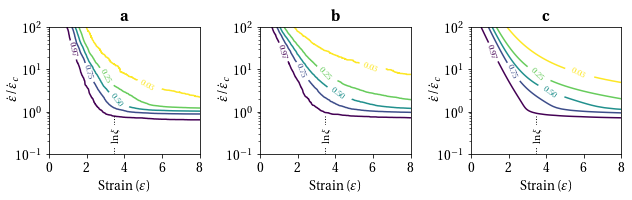

In [234]:
plt.rcParams['figure.figsize'] = [9, 3]
fig, ax = plt.subplots(ncols=3)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]
#ccols = ['#dde318', '#5ec962', '#21918c', '#3b528b', '#440154']

epsilon = dataset['HI']['t']

CS = ax[0].contour(epsilon, ws, cs_noHI, levels, cmap='viridis_r') # viridis_r, YlGnBu
ax[0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[0].set_xlabel('Strain ($\\varepsilon$)')
ax[0].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[0].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0].set_ylim(0.1, 100)
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0].set_title('\\textbf a')


CS = ax[1].contour(epsilon, ws, cs_HI, levels, cmap='viridis_r')
ax[1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[1].set_xlabel('Strain ($\\varepsilon$)')
ax[1].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[1].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1].set_ylim(0.1, 100)
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1].set_title('\\textbf b')


CS = ax[2].contour(epsilon, ws, cs_model, levels, cmap='viridis_r') 
ax[2].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[2].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[2].set_xlabel('Strain ($\\varepsilon$)')
ax[2].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[2].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[2].set_ylim(0.1, 100)
ax[2].set_xlim(0, 8)
ax[2].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[2].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[2].set_title('\\textbf c')

plt.tight_layout()
#plt.savefig('plot_distributions.pdf') 

## Mechanochemical activation versus scission

In [15]:
## With PD = 1.01

data = dataset['elongation_0_noBF_DP1.01']

Wi_c = 200
Wi_m = 100
threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)
print(threshold, mechanophore)

cs_2 = []

# Tensions are going to be rescaled with Wi
Wis = np.logspace(np.log10(Wi_m)-1,np.log10(Wi_m)+2,100)

for Wi in Wis:

    events = np.zeros_like(data['t'])
    for tension_max, tension_centre in zip(Wi*data['L2']/(0.0142*8), Wi*data['M2']/(0.0142*8)):
        for i, (g_max, g_12) in enumerate(zip(tension_max, tension_centre)):
            
            if g_max > threshold or g_12 > mechanophore:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_2.append(c)

cs_2 = np.array(cs_2)

1760.5633802816901 880.2816901408451


In [16]:
Wi_c = 500
Wi_m = 100
threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)
print(threshold, mechanophore)

cs_5 = []

# Tensions are going to be rescaled with Wi
Wis = np.logspace(np.log10(Wi_m)-1,np.log10(Wi_m)+2,100)

for Wi in Wis:

    events = np.zeros_like(data['t'])
    for tension_max, tension_centre in zip(Wi*data['L2']/(0.0142*8), Wi*data['M2']/(0.0142*8)):
        for i, (g_max, g_12) in enumerate(zip(tension_max, tension_centre)):
            
            if g_max > threshold or g_12 > mechanophore:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_5.append(c)

cs_5 = np.array(cs_2)

4401.408450704225 880.2816901408451


In [17]:
def build_model(params):
    c_model = np.ones_like(cs_5)
    
    for i, w in enumerate(Wis/Wi_m):
        kappa = params[0] + params[1]*np.log(w)**2
        f = 1./(1 + np.exp(-np.log(w)/params[2]))
        g = params[3]*np.log((1 + np.exp((dataset['elongation_0_noBF_DP1.01']['epsilon'] - np.log(n_links)/2 + params[4]*np.log(w))/params[3])))
        
        c_model[i] = np.exp(-kappa*f*g)
        
    return c_model


def loss(params):
    return np.sum((cs_5-build_model(params))**2)


from scipy.optimize import minimize
                                    
res = minimize(loss, [0.4, 0.2, 0.1, 0.1, 0.25])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['kappa_0', 'kappa_1', 'gamma_0', 'gamma_1', 'beta_0']
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_model = build_model(res.x)

Optimization terminated successfully.
kappa_0 = 0.386 ± 0.009
kappa_1 = 0.180 ± 0.011
gamma_0 = 0.079 ± 0.005
gamma_1 = 0.169 ± 0.018
beta_0 = 0.224 ± 0.009


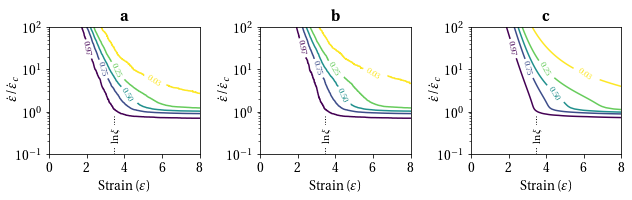

In [18]:
plt.rcParams['figure.figsize'] = [9, 3]
fig, ax = plt.subplots(ncols=3)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]


CS = ax[0].contour(data['epsilon'], Wis/Wi_m, cs_poly, levels, cmap='viridis_r') # viridis_r, YlGnBu
ax[0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[0].set_xlabel('Strain ($\\varepsilon$)')
ax[0].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[0].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0].set_ylim(0.1, 100)
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0].set_title('\\textbf a')


CS = ax[1].contour(data['epsilon'], Wis/Wi_m, cs_5, levels, cmap='viridis_r')
ax[1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[1].set_xlabel('Strain ($\\varepsilon$)')
ax[1].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[1].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1].set_ylim(0.1, 100)
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1].set_title('\\textbf b')


CS = ax[2].contour(data['epsilon'], Wis/Wi_m, c_model, levels, cmap='viridis_r') 
ax[2].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[2].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[2].set_xlabel('Strain ($\\varepsilon$)')
ax[2].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[2].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[2].set_ylim(0.1, 100)
ax[2].set_xlim(0, 8)
ax[2].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[2].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[2].set_title('\\textbf c')

plt.tight_layout()
plt.savefig('plot_distributions_mechanophores.pdf') 

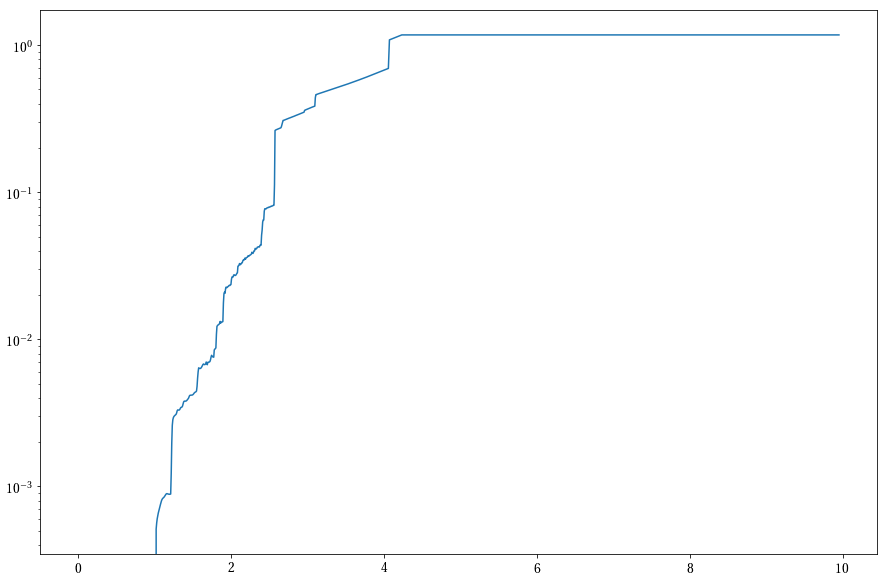

In [124]:
77/24

3.2083333333333335